In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

WBracket_SampleTourney2018.png
WCities.csv
WCities_PrelimData2018.csv
WGameCities.csv
WGameCities_PrelimData2018.csv
WNCAATourneyCompactResults.csv
WNCAATourneyCompactResults_PrelimData2018.csv
WNCAATourneyDetailedResults.csv
WNCAATourneyDetailedResults_PrelimData2018.csv
WNCAATourneySeeds.csv
WNCAATourneySeeds_SampleTourney2018.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonCompactResults_PrelimData2018.csv
WRegularSeasonDetailedResults.csv
WRegularSeasonDetailedResults_PrelimData2018.csv
WSampleSubmissionStage1.csv
WSampleSubmissionStage2.csv
WSampleSubmissionStage2_SampleTourney2018.csv
WSeasons.csv
WSeasons_SampleTourney2018.csv
WTeamSpellings.csv
WTeams.csv



First we import some datasets of interest

In [2]:
#the seed information
df_seeds = pd.read_csv('../input/WNCAATourneySeeds_SampleTourney2018.csv')

#tour information
df_tour = pd.read_csv('../input/WRegularSeasonCompactResults_PrelimData2018.csv')

Now we separate the winners from the losers and organize our dataset

In [3]:
df_seeds['seed_int'] = df_seeds['Seed'].apply( lambda x : int(x[1:3]) )

df_winseeds = df_seeds.loc[:, ['TeamID', 'Season', 'seed_int']].rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.loc[:, ['TeamID', 'Season', 'seed_int']].rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])

Now we match the detailed results to the merge dataset above

In [4]:
df_concat['DiffSeed'] = df_concat[['LSeed', 'WSeed']].apply(lambda x : 0 if x[0] == x[1] else 1, axis = 1)

Here we get our submission info

In [5]:
#prepares sample submission
df_sample_sub = pd.read_csv('../input/WSampleSubmissionStage2.csv')

In [6]:
df_sample_sub['Season'] = df_sample_sub['ID'].apply(lambda x : int(x.split('_')[0]) )
df_sample_sub['TeamID1'] = df_sample_sub['ID'].apply(lambda x : int(x.split('_')[1]) )
df_sample_sub['TeamID2'] = df_sample_sub['ID'].apply(lambda x : int(x.split('_')[2]) )

# Training Data Creation

In [7]:
winners = df_concat.rename( columns = { 'WTeamID' : 'TeamID1', 
                                                       'LTeamID' : 'TeamID2',
                                                      'WScore' : 'Team1_Score',
                                                      'LScore' : 'Team2_Score'}).drop(['WSeed', 'LSeed', 'WLoc'], axis = 1)
winners['Result'] = 1.0

losers = df_concat.rename( columns = { 'WTeamID' : 'TeamID2', 
                                                       'LTeamID' : 'TeamID1',
                                                      'WScore' : 'Team2_Score',
                                                      'LScore' : 'Team1_Score'}).drop(['WSeed', 'LSeed', 'WLoc'], axis = 1)

losers['Result'] = 0.0

train = pd.concat( [winners, losers], axis = 0).reset_index(drop = True)

train['Score_Ratio'] = train['Team1_Score'] / train['Team2_Score']
train['Score_Total'] = train['Team1_Score'] + train['Team2_Score']
train['Score_Pct'] = train['Team1_Score'] / train['Score_Total']

We will only consider years relevant to our test submission

In [8]:
df_sample_sub['Season'].unique()

array([2018])

Now lets just look at TeamID2, or just the second team info.

In [9]:
train_test_inner = pd.merge( train.loc[ train['Season'].isin([2018]), : ].reset_index(drop = True), 
         df_sample_sub.drop(['ID', 'Pred'], axis = 1), 
         on = ['Season', 'TeamID1', 'TeamID2'], how = 'inner' )

In [10]:
train_test_inner.head()

DayNum  DiffSeed  NumOT  Result  Season  Team1_Score  Team2_Score  TeamID1  \
0      11         1      0     1.0    2018           83           67     3234   
1      12         1      0     1.0    2018           66           51     3281   
2      18         1      0     1.0    2018           95           63     3326   
3      40         0      0     1.0    2018           60           46     3343   
4      11         1      0     1.0    2018           68           53     3280   

   TeamID2  Score_Ratio  Score_Total  Score_Pct  
0     3346     1.238806          150   0.553333  
1     3346     1.294118          117   0.564103  
2     3346     1.507937          158   0.601266  
3     3346     1.304348          106   0.566038  
4     3438     1.283019          121   0.561983

From the inner join, we will create data per team id to estimate the parameters we are missing that are independent of the year.  Essentially, we are trying to estimate the average behavior of the team across the year.

In [11]:
team1d_num_ot = train_test_inner.groupby(['Season', 'TeamID1'])['NumOT'].median().reset_index()\
.set_index('Season').rename(columns = {'NumOT' : 'NumOT1'})
team2d_num_ot = train_test_inner.groupby(['Season', 'TeamID2'])['NumOT'].median().reset_index()\
.set_index('Season').rename(columns = {'NumOT' : 'NumOT2'})

num_ot = team1d_num_ot.join(team2d_num_ot).reset_index()

#sum the number of ot calls and subtract by one to prevent overcounting
num_ot['NumOT'] = num_ot[['NumOT1', 'NumOT2']].apply(lambda x : round( x.sum() ), axis = 1 )

num_ot.head()

Season  TeamID1  NumOT1  TeamID2  NumOT2  NumOT
0    2018     3110       0     3141     0.0    0.0
1    2018     3110       0     3143     0.0    0.0
2    2018     3110       0     3163     0.0    0.0
3    2018     3110       0     3177     0.0    0.0
4    2018     3110       0     3179     4.0    4.0

Here we look at the comparable statistics.  For the TeamID2 column, we would consider the inverse of the ratio, and 1 minus the score attempt percentage.

In [12]:
team1d_score_spread = train_test_inner.groupby(['Season', 'TeamID1'])[['Score_Ratio', 'Score_Pct']].median().reset_index()\
.set_index('Season').rename(columns = {'Score_Ratio' : 'Score_Ratio1', 'Score_Pct' : 'Score_Pct1'})
team2d_score_spread = train_test_inner.groupby(['Season', 'TeamID2'])[['Score_Ratio', 'Score_Pct']].median().reset_index()\
.set_index('Season').rename(columns = {'Score_Ratio' : 'Score_Ratio2', 'Score_Pct' : 'Score_Pct2'})

score_spread = team1d_score_spread.join(team2d_score_spread).reset_index()

#geometric mean of score ratio of team 1 and inverse of team 2
score_spread['Score_Ratio'] = score_spread[['Score_Ratio1', 'Score_Ratio2']].apply(lambda x : ( x[0] * ( x[1] ** -1.0) ), axis = 1 ) ** 0.5

#harmonic mean of score pct
score_spread['Score_Pct'] = score_spread[['Score_Pct1', 'Score_Pct2']].apply(lambda x : 0.5*( x[0] ** -1.0 ) + 0.5*( 1.0 - x[1] ) ** -1.0, axis = 1 ) ** -1.0

score_spread.head()

Season  TeamID1  Score_Ratio1  Score_Pct1  TeamID2  Score_Ratio2  \
0    2018     3110      0.822194    0.449524     3141      1.036585   
1    2018     3110      0.822194    0.449524     3143      1.241952   
2    2018     3110      0.822194    0.449524     3163      0.573171   
3    2018     3110      0.822194    0.449524     3177      0.870130   
4    2018     3110      0.822194    0.449524     3179      1.080000   

   Score_Pct2  Score_Ratio  Score_Pct  
0    0.508982     0.890604   0.469356  
1    0.552779     0.813645   0.448369  
2    0.364341     1.197692   0.526628  
3    0.465278     0.972065   0.488436  
4    0.519231     0.872520   0.464622

Now lets create a model just solely based on the inner group and predict those probabilities. 

We will get the teams with the missing result.

In [13]:
X_train = train_test_inner.loc[:, ['Season', 'NumOT', 'Score_Ratio', 'Score_Pct']]
train_labels = train_test_inner['Result']

train_test_outer = pd.merge( train.loc[ train['Season'].isin([2014, 2015, 2016, 2017]), : ].reset_index(drop = True), 
         df_sample_sub.drop(['ID', 'Pred'], axis = 1), 
         on = ['Season', 'TeamID1', 'TeamID2'], how = 'outer' )

train_test_outer = train_test_outer.loc[ train_test_outer['Result'].isnull(), 
                                        ['TeamID1', 'TeamID2', 'Season']]

train_test_missing = pd.merge( pd.merge( score_spread.loc[:, ['TeamID1', 'TeamID2', 'Season', 'Score_Ratio', 'Score_Pct']], 
                   train_test_outer, on = ['TeamID1', 'TeamID2', 'Season']),
         num_ot.loc[:, ['TeamID1', 'TeamID2', 'Season', 'NumOT']],
         on = ['TeamID1', 'TeamID2', 'Season'])

![](http://)We scale our data for our keras classifier, and make sure our categorical variables are properly processed.

In [14]:
X_test = train_test_missing.loc[:, ['Season', 'NumOT', 'Score_Ratio', 'Score_Pct']]

n = X_train.shape[0]

train_test_merge = pd.concat( [X_train, X_test], axis = 0 ).reset_index(drop = True)

train_test_merge = pd.concat( [pd.get_dummies( train_test_merge['Season'].astype(object) ), 
            train_test_merge.drop('Season', axis = 1) ], axis = 1 )

train_test_merge = pd.concat( [pd.get_dummies( train_test_merge['NumOT'].astype(object) ), 
            train_test_merge.drop('NumOT', axis = 1) ], axis = 1 )

X_train = train_test_merge.loc[:(n - 1), :].reset_index(drop = True)
X_test = train_test_merge.loc[n:, :].reset_index(drop = True)

In [15]:
x_max = X_train.max()
x_min = X_train.min()

X_train = ( X_train - x_min ) / ( x_max - x_min + 1e-14)
X_test = ( X_test - x_min ) / ( x_max - x_min + 1e-14)

In [16]:
train_labels.value_counts()

1.0    112
0.0    108
Name: Result, dtype: int64

In [17]:
X_train.head()

0.0  1.0  2.0  4.0  2018  Score_Ratio  Score_Pct
0  1.0  0.0  0.0  0.0   0.0     0.459079   0.623536
1  1.0  0.0  0.0  0.0   0.0     0.496385   0.657950
2  1.0  0.0  0.0  0.0   0.0     0.640596   0.776708
3  1.0  0.0  0.0  0.0   0.0     0.503285   0.664134
4  1.0  0.0  0.0  0.0   0.0     0.488899   0.651178

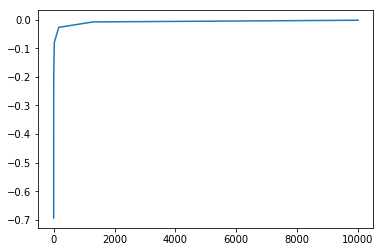

-0.6928690068542296

In [18]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(cv=80,scoring="neg_log_loss",random_state=1
                             #,penalty="l1"
                             #,Cs= Cs_#list(np.arange(1e-7,1e-9,-0.5e-9)) # [0.5,0.1,0.01,0.001] #list(np.power(1, np.arange(-10, 10)))
                             #,max_iter=1000, tol=1e-11
                             #,solver="liblinear"
                             #,n_jobs=4
                            )
model.fit(X_train, train_labels)

#---
Cs = model.Cs_
list(np.power(10.0, np.arange(-10, 10)))
dir(model)
sco = model.scores_[1].mean(axis=0)
#---
import matplotlib.pyplot as plt
plt.plot(Cs
    #np.log10(Cs)
    ,sco)
# plt.ylabel('some numbers')
plt.show()
sco.min()

In [19]:
Cs_= list(np.arange(1.1e-9 - 5e-11
                    ,1.051e-9 
                    ,0.2e-13))
len(Cs_)

51

In [20]:
Cs_= list(np.arange(1e-11
                    ,9.04e-11#1.0508e-9 
                    ,0.2e-12))
len(Cs_)

402

In [21]:
#Cs_= list(np.arange(5.6e-13             - ( (0.01e-13)*1)
#                    ,5.61e-13            - ( (0.01e-13)*1)#1.0508e-9 
#                    ,0.2e-15))
#len(Cs_)

In [22]:
Cs_= list(np.arange(1e-11
                    ,5.5e-11#1.0508e-9 
                    ,0.2e-12))
len(Cs_)

225

In [23]:
Cs_= list(np.arange(1e-14
                    ,5.5e-11#1.0508e-9 
                    ,0.2e-12))
len(Cs_)#awsome

275

In [24]:
#Cs_= list(np.arange(1.5e-11
#                    ,2.53e-11#1.0508e-9 
#                    ,0.2e-13)) #+[3.761e-11]
#len(Cs_)

In [25]:
#X_train.dtypes

In [26]:
Cs_= list(np.arange(1e-15
                    ,0.51e-10 #1.0508e-9 
                    ,0.1e-12))
len(Cs_)#new again

510

In [27]:
Cs_= list(np.arange(9e-14
                    ,10.1e-13 #1.0508e-9 
                    ,0.1e-14))
len(Cs_)#new again cont. lowerlevel

920

In [28]:
Cs_= list(np.linspace(1e-19
                    ,0.610e-11 #1.0508e-9 
                    ,500))
len(Cs_)#new again cont. lowerlevel

500

In [29]:
Cs_= list(np.logspace(-12.5715
                    ,-12.5714 #1.0508e-9 
                    ,500))
len(Cs_)#new again cont. lowerlevel

500

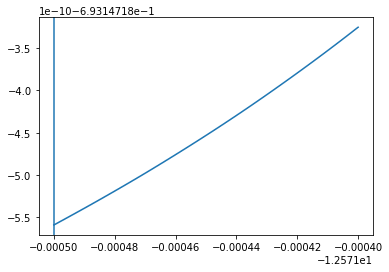

In [30]:
#LogisticRegressionCV(Cs=10, class_weight=None, cv=107, dual=False,
#           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
#           multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
#           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
#           verbose=0) #-0.7
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(cv=80,scoring="neg_log_loss",random_state=1
                             #,penalty="l1"
                             ,Cs= Cs_#list(np.arange(1e-7,1e-9,-0.5e-9)) # [0.5,0.1,0.01,0.001] #list(np.power(1, np.arange(-10, 10)))
                             ,max_iter=1000, tol=1e-11
                             #,solver="liblinear"
                             ,n_jobs=4)
model.fit(X_train, train_labels)

#---
Cs = model.Cs_
list(np.power(10.0, np.arange(-10, 10)))
dir(model)
sco = model.scores_[1].mean(axis=0)
#---
import matplotlib.pyplot as plt
plt.plot(#Cs
    np.log10(Cs)
    ,sco)
# plt.ylabel('some numbers')
index_min = np.argmin(sco)
Cs_[index_min]
plt.axvline(x=np.log10(Cs_[index_min]))

plt.show()

In [31]:
index_min = np.argmin(sco)
Cs_[index_min] #3.761e-11

2.6822546076084914e-13

In [32]:
#list(np.power(10.0, np.arange(-10, 10)))
#list(np.arange(0.5,1e-4,-0.05))
print(sco.max())
#-0.6931471779248422
print(sco.min() < -0.693270048530996)
print(sco.min()+0.693270048530996)
sco.min()

-0.69314718032509
False
0.0001228679716934744


-0.6931471805593026

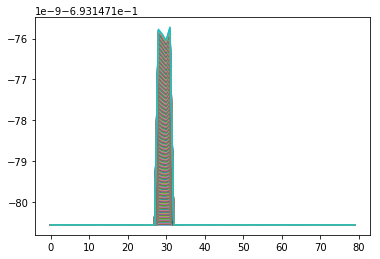

In [33]:
import matplotlib.pyplot as plt
plt.plot(model.scores_[1])
# plt.ylabel('some numbers')
plt.show()

Here we store our probabilities

In [34]:
train_test_inner['Pred1'] = model.predict_proba(X_train)[:,1]
train_test_missing['Pred1'] = model.predict_proba(X_test)[:,1]

We merge our predictions

In [35]:
sub = pd.merge(df_sample_sub, 
                         pd.concat( [train_test_missing.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']],
                                     train_test_inner.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']] ],
                                   axis = 0).reset_index(drop = True),
                  on = ['Season', 'TeamID1', 'TeamID2'], how = 'outer')

We get the 'average' probability of success for each team

In [36]:
team1_probs = sub.groupby('TeamID1')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
team2_probs = sub.groupby('TeamID2')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()

Any missing value for the prediciton will be imputed with the product of the probabilities calculated above.  We assume these are independent events.

In [37]:
sub['Pred'] = sub[['TeamID1', 'TeamID2','Pred1']]\
.apply(lambda x : team1_probs.get(x[0]) * ( 1 - team2_probs.get(x[1]) ) if np.isnan(x[2]) else x[2], 
       axis = 1)

In [38]:
sub = sub.drop_duplicates(subset=["ID"], keep='first')

sub[['ID', 'Pred']].to_csv('sub.csv', index = False)

In [39]:
sub[['ID', 'Pred']].head(20)

ID  Pred
0   2018_3110_3113  0.25
1   2018_3110_3114  0.25
2   2018_3110_3124  0.25
3   2018_3110_3125  0.25
4   2018_3110_3129  0.25
5   2018_3110_3138  0.25
6   2018_3110_3141  0.50
7   2018_3110_3143  0.50
8   2018_3110_3163  0.50
9   2018_3110_3166  0.25
10  2018_3110_3169  0.25
11  2018_3110_3173  0.25
12  2018_3110_3177  0.50
13  2018_3110_3179  0.50
14  2018_3110_3181  0.25
15  2018_3110_3189  0.25
16  2018_3110_3195  0.50
17  2018_3110_3199  0.50
18  2018_3110_3203  0.50
20  2018_3110_3208  0.25